In [1]:
import warnings

warnings.filterwarnings("ignore")

# Tiling system

`pytileproj`'s `tiling_system` module defines several classes representing a multi-level (e.g., zoom, tiling level, ...) projected tiling scheme. A tiling system is a collection of tilings defined in `pytileproj.tiling`, i.e., regular and irregular tilings. These tilings can then be ordered by their tiling/zoom level and forced to only allow certain pixel spacings at a specific level. In the following section, we will look at the most common use case of a tiling system, i.e., a regular projected tiling system. 

## Regular projected tiling system

`pytileproj`'s regular tiling system class `RegularProjTilingSystem` exptects the following arguments:

- `name`: Name of the tiling system.
- `crs`: A spatial reference system represented by anything pyproj supports, e.g., EPSG code, PROJ4 string, WKT string, ...
- `tilings`: Dictionary linking tiling/zoom levels to regular tilings.
- `proi_zone_geog` (optional): Projection zone in geographic coordinates. If not given, the zone is fetched from the EPSG registry.

### Initialisation

Lets dive deeper into how a `RegularProjTilingSystem` can be used. As an example, we want to create tiling system for the European Equi7Grid projection. First, we need to define the tilings we want to use within the system:

In [2]:
from pytileproj.tiling import RegularTiling

extent = (0, 0, 8_700_000, 6_000_000)
axis_orientation = ("E", "S")
coarse_tiling = RegularTiling(
    name="my_coarse_tiling",
    extent=extent,
    sampling=1_000,
    tile_shape=(300_000, 300_000),
    tiling_level=1,
    axis_orientation=axis_orientation,
)
fine_tiling = RegularTiling(
    name="my_fine_tiling",
    extent=extent,
    sampling=10,
    tile_shape=(100_000, 100_000),
    tiling_level=2,
    axis_orientation=axis_orientation,
)

Then, we can create a `RegularProjTilingSystem` by attaching the respective EPSG code:

In [ ]:
from pathlib import Path

from pytileproj import RegularProjTilingSystem

name = "e7eu"
epsg = 27704

# this argument is only optional, but in case the EPSG API is down,
# it needs to be provided
proj_zone_geog = Path("../../tests/data/eu_zone.parquet")

rpts = RegularProjTilingSystem(
    name=name,
    tilings={tiling.tiling_level: tiling for tiling in [coarse_tiling, fine_tiling]},
    crs=epsg,
    proj_zone_geog=proj_zone_geog,
)
rpts

RegularProjTilingSystem(crs=27704, proj_zone_geog=GeogGeom(geom=<POLYGON ((50.065 62.864, 50.061 62.964, 50.058 63.064, 50.055 63.164, 50.05...>, crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
), name='e7eu', tilings={1: RegularTiling(name='my_coarse_tiling', extent=(0.0, 0.0, 8700000.0, 6000000.0), sampling=1000.0, tile_shape=(300000.0, 300000.0), tiling_level=1, axis_orientation=('E', 'S')), 2: RegularTiling(name='my_fine_tiling', extent=(0.0, 0.0, 8700000.0, 6000000.0), sampling=10.0, tile_shape=(100000.0, 100000.0), tiling_level=2, axis_orientation=('E', 'S'))})

`RegularProjTilingSystem` also provides another method to create an object from tiling definitions, which directly assume that a regular projected tiling system has the same extent and axis orientation. In addition, the user has control over the tile size in projection units rather than the tile shape in pixels:

In [ ]:
from pytileproj.tiling_system import ProjSystemDefinition, RegularTilingDefinition

rpts_def = ProjSystemDefinition(
    name=name,
    crs=epsg,
    min_xy=extent[:2],
    max_xy=extent[2:],
    axis_orientation=axis_orientation,
    proj_zone_geog=proj_zone_geog,
)
tiling_defs = {
    1: RegularTilingDefinition(name="my_coarse_tiling", tile_shape=300_000),
    2: RegularTilingDefinition(name="my_fine_tiling", tile_shape=100_000),
}
rpts = RegularProjTilingSystem.from_sampling(
    {1: 1_000, 2: 10},
    proj_def=rpts_def,
    tiling_defs=tiling_defs,
)

### Projection system interactions

Often it is required to transform coordinates back and forth between different projection systems. `RegularProjTilingSystem` provides several methods to do this in a straighforward way. If you want transform geographic coordinates to projected coordinates, you can use `lonlat_to_xy`:

In [5]:
lon, lat = 16.3926, 48.1674
proj_coord = rpts.lonlat_to_xy(lon, lat)
proj_coord

ProjCoord(x=5271748.127753316, y=1613228.4676009014, crs=<Projected CRS: EPSG:27704>
Name: WGS 84 / Equi7 Europe
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe including Russia west of the Ural Mountains.
- bounds: (-42.52, 29.24, 51.73, 83.67)
Coordinate Operation:
- name: Equi7 projection - Europe
- method: Azimuthal Equidistant
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
)

The same can be done the other way around:

In [6]:
rpts.xy_to_lonlat(proj_coord.x, proj_coord.y)

GeogCoord(x=16.392599999999998, y=48.1674, crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
)

Note that for coordinates outside the projection zone, an error will be raised:

In [7]:
lon, lat = -100, 30
rpts.lonlat_to_xy(lon, lat)

GeomOutOfZoneError: The given Point ('POINT (-100 30)') is not within the zone boundaries of the projection.

You can check in advance if a point or geometry is within the projection by using Python's `in` operator:

In [8]:
import pyproj

from pytileproj import ProjCoord

coord = ProjCoord(lon, lat, pyproj.CRS.from_epsg(4326))
coord in rpts

False

If you want to know the units of the projection system, you can retrieve this information via:

In [9]:
rpts.unit

'metre'

### Tiles

Regular projected tiling systems create tiles on the fly, since their regular tiling scheme allows an efficient computation of tile properties. If you want to know if the tilings within the tiling systems are congruent, i.e., tiles at a higher tiling level (fine tiling) are multiples of tiles at a lower tiling level (coarse tiling), you can use the `is_congruent` property. 

In [10]:
rpts.is_congruent

True

A tile can be created by providing a location of interest with the following methods: `get_tile_from_lonlat`, `get_tile_from_xy`, and `get_tile_from_coord`. Here is an example:

In [11]:
lon, lat = 16.3926, 48.1674
rpts.get_tile_from_lonlat(lon, lat, tiling_id=1)

RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5100000.0, 1000.0, 0.0, 1800000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X17Y14T01')

In addition, you can create a tile by using an OGC tile index (x, y, z):

In [12]:
rpts.get_tile_from_index(17, 5, 1)

RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5100000.0, 1000.0, 0.0, 4500000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X17Y05T01')

If you are interested in retrieving a list of tiles intersecting with a region of interest in geographic coordinates, you can use `get_tiles_in_geog_bbox`. It returns a generator to enable lazy tile retrieval.

In [13]:
list(rpts.get_tiles_in_geog_bbox((16, 48, 18, 50), tiling_id="my_fine_tiling"))

[RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5400000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X54Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5400000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X54Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1700000.0, 0.0, -10.0), px_origin='

:::{important}
For a geographical bounding box the order of longitude coordinates is important. As an example: `(-170, 20, 150, 30)` is a large bounding box going from -170° west to 150° east and `(150, 20, -170, 30)` is a small bounding box crossing the antimeridian.
:::

Similar queries can be done with native coordinates 

In [14]:
list(
    rpts.get_tiles_in_bbox(
        (5155982, 1505898, 6323863, 2140396), tiling_id="my_coarse_tiling"
    )
)

[RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5100000.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X17Y12T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5400000.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X18Y12T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5700000.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X19Y12T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(6000000.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X20Y12T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(6300000.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X21Y12T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5100000.0, 1000.0, 0.0, 2100000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X17Y13T01'),
 RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5400000.0, 1000.0, 0.0, 2100000.0, 0.0, -1000.0), px_origin='

or by using a geometry.

In [15]:
from shapely import Polygon

from pytileproj import GeogGeom

geom = Polygon([(16, 48), (18, 48), (18, 50), (16, 50)])
ggeom = GeogGeom(geom=geom)
list(rpts.get_tiles_in_geom(ggeom, tiling_id="my_fine_tiling"))

[RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5400000.0, 10.0, 0.0, 1900000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X54Y41T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5400000.0, 10.0, 0.0, 1800000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X54Y42T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 1700000.0, 0.0, -10.0), px_origin='

:::{note}
All geometries passed to `pytileproj` functions and class methods are segmentised to ensure an adequate representation of the geometry in a different projection system. A maximum segment length is defined as
- 0.1 degree for geographic projections
- 10 kilometres for metric projections
:::

Since tiling systems represent an hierarchy of different tilings, `pytileproj` also allows to trace parent and children tiles. You can obtain the parent of a tile with

In [16]:
rpts.get_parent_from_name("X53Y17T02")

RasterTile(crs=27704, n_rows=300, n_cols=300, geotrans=(5100000.0, 1000.0, 0.0, 4500000.0, 0.0, -1000.0), px_origin='ul', name='e7eu_X17Y05T01')

and the children with

In [17]:
list(rpts.get_children_from_name("X17Y05T01"))

[RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5100000.0, 10.0, 0.0, 4500000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X51Y15T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 4500000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y15T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 4500000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y15T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5100000.0, 10.0, 0.0, 4400000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X51Y16T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5200000.0, 10.0, 0.0, 4400000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X52Y16T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5300000.0, 10.0, 0.0, 4400000.0, 0.0, -10.0), px_origin='ul', name='e7eu_X53Y16T02'),
 RasterTile(crs=27704, n_rows=10000, n_cols=10000, geotrans=(5100000.0, 10.0, 0.0, 4300000.0, 0.0, -10.0), px_origin='

### Export


:::{note}
The export methods requires additional depencies, which are not installed by default. You can install them via `uv pip install pytileproj[geo]`.
:::


A tiling system offers several export methods, e.g., an export to a `GeoDataFrame` (`to_geodataframe`) or a shapefile (`to_shapefile`). Here is an example how to generate a `GeoDataFrame`:

In [18]:
rpts.to_geodataframe()

,n_rows,n_cols,geotrans,px_origin,name,tiling_name,tiling_level,geometry
0,300,300,"(0.0, 1000.0, 0.0, 2700000.0, 0.0, -1000.0)",ul,e7eu_X00Y11T01,my_coarse_tiling,1,"POLYGON ((0 2400000, 300000 2400000, 300000 27..."
1,300,300,"(0.0, 1000.0, 0.0, 2400000.0, 0.0, -1000.0)",ul,e7eu_X00Y12T01,my_coarse_tiling,1,"POLYGON ((0 2100000, 300000 2100000, 300000 24..."
2,300,300,"(0.0, 1000.0, 0.0, 2100000.0, 0.0, -1000.0)",ul,e7eu_X00Y13T01,my_coarse_tiling,1,"POLYGON ((0 1800000, 300000 1800000, 300000 21..."
3,300,300,"(300000.0, 1000.0, 0.0, 3000000.0, 0.0, -1000.0)",ul,e7eu_X01Y10T01,my_coarse_tiling,1,"POLYGON ((300000 2700000, 600000 2700000, 6000..."
4,300,300,"(300000.0, 1000.0, 0.0, 2700000.0, 0.0, -1000.0)",ul,e7eu_X01Y11T01,my_coarse_tiling,1,"POLYGON ((300000 2400000, 600000 2400000, 6000..."
...,...,...,...,...,...,...,...,...
3098,10000,10000,"(8100000.0, 10.0, 0.0, 1100000.0, 0.0, -10.0)",ul,e7eu_X81Y49T02,my_fine_tiling,2,"POLYGON ((8100000 1000000, 8200000 1000000, 82..."
3099,10000,10000,"(8100000.0, 10.0, 0.0, 1000000.0, 0.0, -10.0)",ul,e7eu_X81Y50T02,my_fine_tiling,2,"POLYGON ((8100000 900000, 8200000 900000, 8200..."
3100,10000,10000,"(8100000.0, 10.0, 0.0, 900000.0, 0.0, -10.0)",ul,e7eu_X81Y51T02,my_fine_tiling,2,"POLYGON ((8100000 800000, 8200000 800000, 8200..."
3101,10000,10000,"(8200000.0, 10.0, 0.0, 1000000.0, 0.0, -10.0)",ul,e7eu_X82Y50T02,my_fine_tiling,2,"POLYGON ((8200000 900000, 8300000 900000, 8300..."


If you want to share an OGC compliant definition of the tiling system, you can use `to_ogc_standard` or `to_ogc_json`:

In [19]:
import json
import pprint
from pathlib import Path

ogc_ts_path = Path("my_tiling_system.json")
rpts.to_ogc_json(ogc_ts_path)

with ogc_ts_path.open() as f:
    ogc_ts = json.load(f)

pprint.pprint(ogc_ts)  # noqa: T203

{'boundingBox': None,
 'crs': {'wkt': {'$schema': 'https://proj.org/schemas/v0.7/projjson.schema.json',
                 'area': 'Europe including Russia west of the Ural Mountains.',
                 'base_crs': {'coordinate_system': {'axis': [{'abbreviation': 'Lat',
                                                              'direction': 'north',
                                                              'name': 'Geodetic '
                                                                      'latitude',
                                                              'unit': 'degree'},
                                                             {'abbreviation': 'Lon',
                                                              'direction': 'east',
                                                              'name': 'Geodetic '
                                                                      'longitude',
                                                              'unit':

In [20]:
ogc_ts_path.unlink(missing_ok=True)

### Visualisation

A `RegularProjTilingSystem` can be also visualised on a map in a similar manner as a `RasterTile` object, if the optional dependencies `matplotlib` and `cartopy` are installed.

<GeoAxes: >

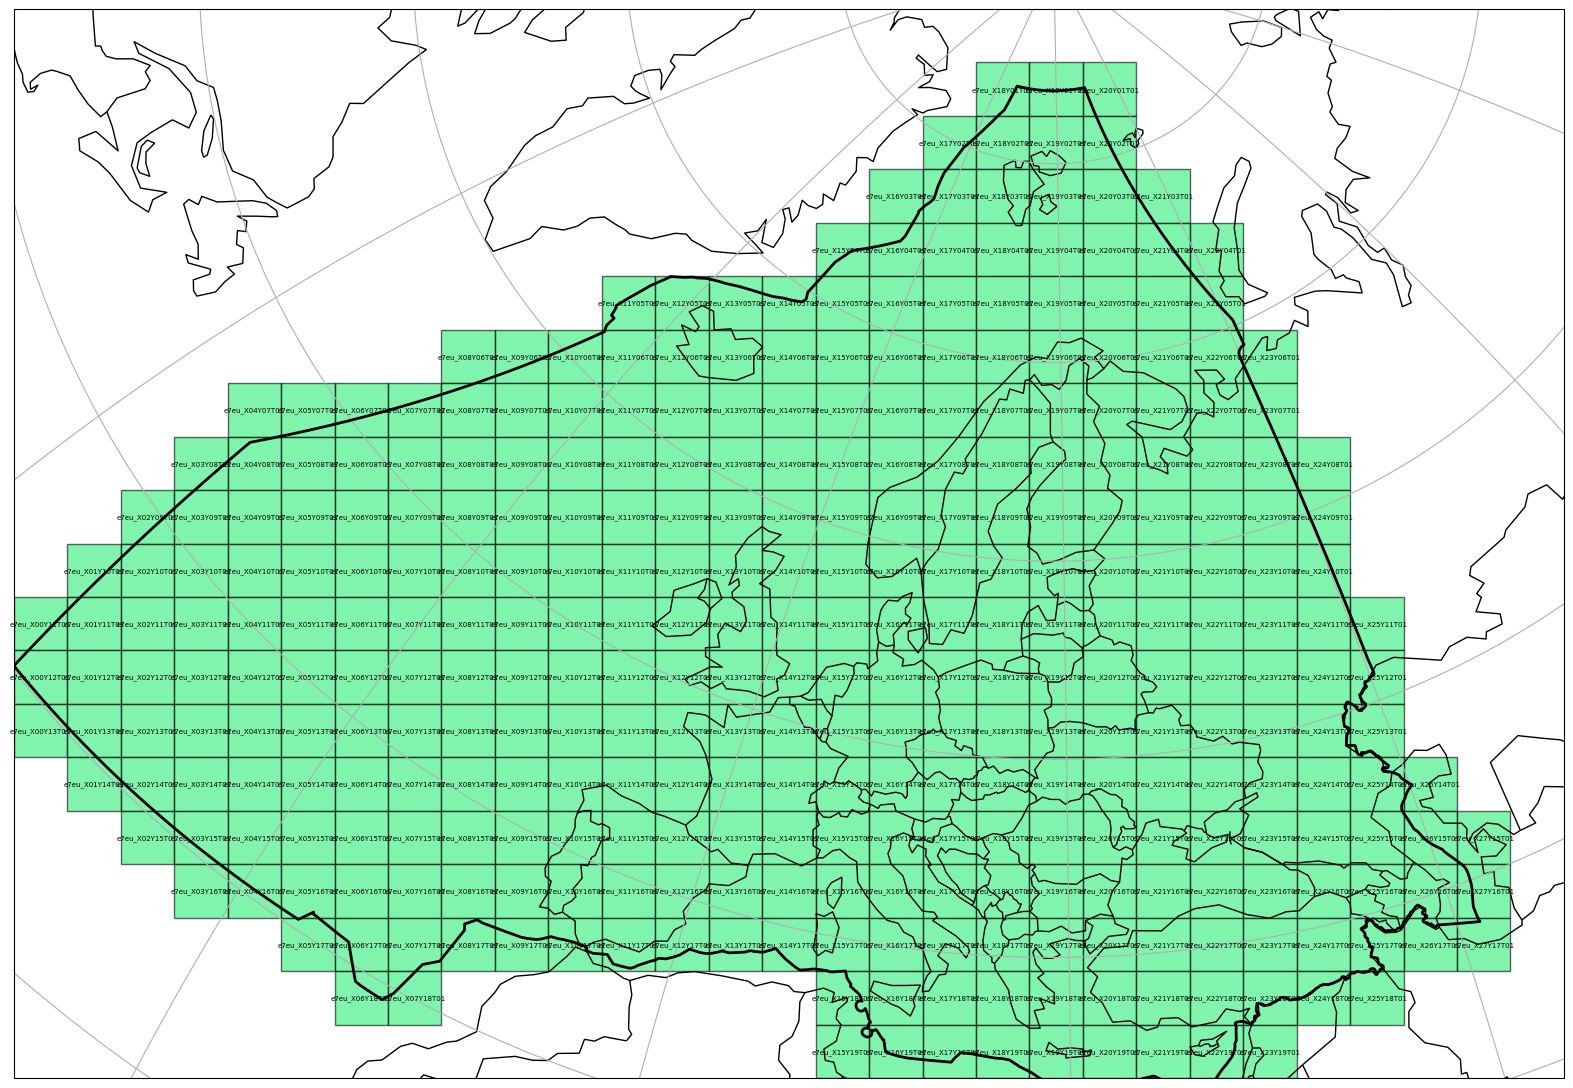

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 28))
_ = rpts.plot(
    tiling_id=1,
    label_tile=True,
    label_size=5,
    plot_zone=True,
    facecolor="#2cee768f",
    alpha=0.6,
    extent=extent,
)